In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/alzheimer-data
/kaggle/input/alzheimer-data/derivatives
/kaggle/input/alzheimer-data/derivatives/sub-088
/kaggle/input/alzheimer-data/derivatives/sub-088/eeg
/kaggle/input/alzhaimer
/kaggle/input/alzhaimer/ds004504-main
/kaggle/input/alzhaimer/ds004504-main/sub-060
/kaggle/input/alzhaimer/ds004504-main/sub-060/eeg
/kaggle/input/alzhaimer/ds004504-main/sub-003
/kaggle/input/alzhaimer/ds004504-main/sub-003/eeg
/kaggle/input/alzhaimer/ds004504-main/sub-012
/kaggle/input/alzhaimer/ds004504-main/sub-012/eeg
/kaggle/input/alzhaimer/ds004504-main/sub-057
/kaggle/input/alzhaimer/ds004504-main/sub-057/eeg
/kaggle/input/alzhaimer/ds004504-main/sub-015
/kaggle/input/alzhaimer/ds004504-main/sub-015/eeg
/kaggle/input/alzhaimer/ds004504-main/sub-048
/kaggle/input/alzhaimer/ds004504-main/sub-048/eeg
/kaggle/input/alzhaimer/ds004504-main/sub-034
/kaggle/input/alzhaimer/ds004504-main/sub-034/eeg
/kaggle/input/alzhaimer/ds004504-main/sub-010
/kaggle/input/alzhaimer/ds004504-m

In [23]:
!pip install gdown

In [ ]:
!pip install -q pymatreader

In [18]:
!pip install --upgrade mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 67.4 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: mne
    Found existing installation: mne 1.8.0
    Uninstalling mne-1.8.0:
      Successfully uninstalled mne-1.8.0


In [2]:
import os
import pandas as pd
import mne
import numpy as np
import random

# Step 1: Load Metadata from Participants.tsv
participants_file = '/kaggle/input/alzheimer-full/ds004504-1.0.7/participants.tsv'
participants_df = pd.read_csv(participants_file, sep='\t')

# Keep only relevant columns: participant_id and group (ignoring MMSE and Age)
participants_df = participants_df[['participant_id', 'Group']]

# Create a dictionary to map participant_id to group
group_mapping = participants_df.set_index('participant_id')['Group'].to_dict()

# Step 2: Load and Segment EEG Signals with Overlap
# Directory containing the EEG data
data_dir = '/kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/'

# Parameters for segmentation
segment_length_sec = 5  # length of each segment in seconds
sampling_rate = 500  # Hz
segment_length = segment_length_sec * sampling_rate  # Number of data points per segment

# Parameters for overlap
overlap_ratio = 0.5  # 50% overlap
overlap_step = int(segment_length * (1 - overlap_ratio))  # Step size considering overlap

data_segments = []
group_labels = []

# Iterate over each subject folder to load EEG data
directories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and d != '.DS_Store']

directories.sort(key=lambda x: int(x.split('-')[1]))

# Define the slice boundaries and the number of samples per slice
slice_boundaries = [(0, 36), (37, 65), (66, len(directories))]
samples_per_slice = 18

selected_samples = []
remaining_directories = directories[:]  # Start with all directories as remaining

for start, end in slice_boundaries:
    slice_directories = remaining_directories[start:end]
    # Randomly select samples from the current slice
    slice_samples = random.sample(slice_directories, min(samples_per_slice, len(slice_directories)))
    selected_samples.extend(slice_samples)
    # Remove the selected directories from the remaining list
    remaining_directories = [dir for dir in remaining_directories if dir not in slice_samples]

print("Selected Samples:", selected_samples)
print("Number of Selected Samples:", len(selected_samples))
print("Remaining Directories:", remaining_directories)
print("Number of Remaining Directories:", len(remaining_directories))

for participant_id in selected_samples:
    participant_folder = os.path.join(data_dir, participant_id)
    
    if participant_id in group_mapping:
        # Load the EEG data
        eeg_file = os.path.join(participant_folder, 'eeg', f'{participant_id}_task-eyesclosed_eeg.set')
        print("Looking for EEG file:", eeg_file)
        
        if os.path.exists(eeg_file):
            print(f"Loading EEG data for {participant_id}...")
            raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
            
            # Get the EEG data as a numpy array
            data = raw.get_data()  # Shape: (n_channels, n_samples)
            n_channels, n_samples = data.shape
            
            # Segment the data with overlap
            start = 0
            while start + segment_length <= n_samples:
                end = start + segment_length
                segment = data[:, start:end]
                
                # Append the segment and corresponding group label
                data_segments.append(segment)
                group_labels.append(group_mapping[participant_id])
                
                # Move to the next segment considering overlap
                start += overlap_step

        else:
            print(f"EEG file not found for participant: {participant_id}")

# Convert lists to numpy arrays
data_segments = np.array(data_segments)  # Shape: (n_segments, n_channels, segment_length)
group_labels = np.array(group_labels)

# Print the shapes of the segmented data and labels
print("Data Segments Shape (with overlap):", data_segments.shape)
print("Group Labels Shape:", group_labels.shape)


Selected Samples: ['sub-038', 'sub-004', 'sub-029', 'sub-009', 'sub-023', 'sub-027', 'sub-019', 'sub-024', 'sub-040', 'sub-036', 'sub-012', 'sub-022', 'sub-008', 'sub-026', 'sub-030', 'sub-032', 'sub-007', 'sub-001', 'sub-084', 'sub-073', 'sub-076', 'sub-082', 'sub-080', 'sub-063', 'sub-075', 'sub-085', 'sub-061', 'sub-087', 'sub-071', 'sub-069', 'sub-066', 'sub-074', 'sub-078', 'sub-068', 'sub-065', 'sub-062']
Number of Selected Samples: 36
Remaining Directories: ['sub-002', 'sub-003', 'sub-005', 'sub-006', 'sub-010', 'sub-011', 'sub-013', 'sub-014', 'sub-015', 'sub-016', 'sub-017', 'sub-020', 'sub-021', 'sub-028', 'sub-031', 'sub-035', 'sub-037', 'sub-039', 'sub-041', 'sub-042', 'sub-043', 'sub-044', 'sub-045', 'sub-046', 'sub-047', 'sub-048', 'sub-049', 'sub-050', 'sub-051', 'sub-052', 'sub-053', 'sub-054', 'sub-055', 'sub-056', 'sub-057', 'sub-058', 'sub-059', 'sub-060', 'sub-064', 'sub-067', 'sub-070', 'sub-072', 'sub-077', 'sub-079', 'sub-081', 'sub-083', 'sub-086', 'sub-088']
Nu

<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-004/eeg/sub-004_task-eyesclosed_eeg.set
Loading EEG data for sub-004...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-029/eeg/sub-029_task-eyesclosed_eeg.set
Loading EEG data for sub-029...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-009/eeg/sub-009_task-eyesclosed_eeg.set
Loading EEG data for sub-009...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-023/eeg/sub-023_task-eyesclosed_eeg.set
Loading EEG data for sub-023...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-027/eeg/sub-027_task-eyesclosed_eeg.set
Loading EEG data for sub-027...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-019/eeg/sub-019_task-eyesclosed_eeg.set
Loading EEG data for sub-019...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-024/eeg/sub-024_task-eyesclosed_eeg.set
Loading EEG data for sub-024...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-040/eeg/sub-040_task-eyesclosed_eeg.set
Loading EEG data for sub-040...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-036/eeg/sub-036_task-eyesclosed_eeg.set
Loading EEG data for sub-036...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-012/eeg/sub-012_task-eyesclosed_eeg.set
Loading EEG data for sub-012...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-022/eeg/sub-022_task-eyesclosed_eeg.set
Loading EEG data for sub-022...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-008/eeg/sub-008_task-eyesclosed_eeg.set
Loading EEG data for sub-008...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-026/eeg/sub-026_task-eyesclosed_eeg.set
Loading EEG data for sub-026...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-030/eeg/sub-030_task-eyesclosed_eeg.set
Loading EEG data for sub-030...
Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-032/eeg/sub-032_task-eyesclosed_eeg.set
Loading EEG data for sub-032...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-007/eeg/sub-007_task-eyesclosed_eeg.set
Loading EEG data for sub-007...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-001/eeg/sub-001_task-eyesclosed_eeg.set
Loading EEG data for sub-001...
Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-084/eeg/sub-084_task-eyesclosed_eeg.set
Loading EEG data for sub-084...
Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-073/eeg/sub-073_task-eyesclosed_eeg.set
Loading EEG data for sub-073...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-076/eeg/sub-076_task-eyesclosed_eeg.set
Loading EEG data for sub-076...
Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-082/eeg/sub-082_task-eyesclosed_eeg.set
Loading EEG data for sub-082...
Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-080/eeg/sub-080_task-eyesclosed_eeg.set
Loading EEG data for sub-080...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-063/eeg/sub-063_task-eyesclosed_eeg.set
Loading EEG data for sub-063...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-075/eeg/sub-075_task-eyesclosed_eeg.set
Loading EEG data for sub-075...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-085/eeg/sub-085_task-eyesclosed_eeg.set
Loading EEG data for sub-085...
Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-061/eeg/sub-061_task-eyesclosed_eeg.set
Loading EEG data for sub-061...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-087/eeg/sub-087_task-eyesclosed_eeg.set
Loading EEG data for sub-087...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-071/eeg/sub-071_task-eyesclosed_eeg.set
Loading EEG data for sub-071...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-069/eeg/sub-069_task-eyesclosed_eeg.set
Loading EEG data for sub-069...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-066/eeg/sub-066_task-eyesclosed_eeg.set
Loading EEG data for sub-066...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-074/eeg/sub-074_task-eyesclosed_eeg.set
Loading EEG data for sub-074...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-078/eeg/sub-078_task-eyesclosed_eeg.set
Loading EEG data for sub-078...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-068/eeg/sub-068_task-eyesclosed_eeg.set
Loading EEG data for sub-068...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-065/eeg/sub-065_task-eyesclosed_eeg.set
Loading EEG data for sub-065...
Looking for EEG file: /kaggle/input/alzheimer-full/ds004504-1.0.7/derivatives/sub-062/eeg/sub-062_task-eyesclosed_eeg.set
Loading EEG data for sub-062...


<ipython-input-2-21af95aa06ca>:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)


Data Segments Shape (with overlap): (11063, 19, 2500)
Group Labels Shape: (11063,)


In [3]:
from sklearn.preprocessing import StandardScaler

# Step 3: Standardize Each Segment
scaler = StandardScaler()
standardized_segments = []

for segment in data_segments:
    # Standardize each channel independently
    standardized_segment = scaler.fit_transform(segment)
    standardized_segments.append(standardized_segment)

# Convert the standardized segments list to a numpy array
standardized_segments = np.array(standardized_segments)

# Print the shape of standardized segments
print("Standardized Segments Shape:", standardized_segments.shape)


Standardized Segments Shape: (11063, 19, 2500)


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Step 4: Define and Train the Autoencoder
input_shape = standardized_segments.shape[1:]  # Shape: (n_channels, segment_length)
latent_dim = 32  # Dimension of the latent space (modifiable)

# Define the encoder part of the autoencoder
input_layer = Input(shape=input_shape)
flattened = tf.keras.layers.Flatten()(input_layer)
encoded = Dense(128, activation='relu')(flattened)
encoded = Dense(latent_dim, activation='relu')(encoded)

# Define the decoder part of the autoencoder
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(np.prod(input_shape), activation='linear')(decoded)
decoded = tf.keras.layers.Reshape(input_shape)(decoded)

# Build the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(
    standardized_segments, 
    standardized_segments,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_split=0.2
)

# Define the encoder model to extract features
encoder = Model(inputs=input_layer, outputs=encoded)

# Extract features for all segments
encoded_segments = encoder.predict(standardized_segments)

# Print the shape of the encoded segments
print("Encoded Segments Shape:", encoded_segments.shape)


Epoch 1/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.9824 - val_loss: 0.9430
Epoch 2/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9423 - val_loss: 0.9188
Epoch 3/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9216 - val_loss: 0.9050
Epoch 4/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9080 - val_loss: 0.8962
Epoch 5/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9004 - val_loss: 0.8895
Epoch 6/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8946 - val_loss: 0.8865
Epoch 7/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8904 - val_loss: 0.8860
Epoch 8/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8894 - val_loss: 0.8847
Epoch 9/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8872 - val_loss: 0.8823
Epoch 10/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.8868 - val_loss: 0.8827
Epoch 11/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.8841 - val_loss: 0.8825
Epoch 12/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/ste

In [15]:
encoder.save('encoder_model.h5')

In [5]:
import numpy as np
import scipy.signal as signal
import scipy.integrate as integrate

# Définition des bandes de fréquence (incluant Gamma)
frequency_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 25),
    'gamma': (25, 45)
}

# Taux d'échantillonnage des données EEG (en Hz)
sampling_rate = 128

def extract_band_power(segments, frequency_bands, sampling_rate):
    """
    Extrait la puissance des bandes de fréquence pour chaque segment EEG encodé.
    
    Args:
        segments (np.array): Segments encodés (N_segments, N_features)
        frequency_bands (dict): Dictionnaire des bandes de fréquence à extraire
        sampling_rate (int): Taux d'échantillonnage des données EEG
        
    Returns:
        np.array: Puissances des bandes de fréquence pour chaque segment
    """
    band_powers = []
    for segment in segments:
        # Calcul du spectre de puissance (PSD)
        freqs, psd = signal.welch(segment, fs=sampling_rate, nperseg=len(segment))
        
        # Calcul de la puissance pour chaque bande de fréquence définie
        band_power = []
        for band, (low_freq, high_freq) in frequency_bands.items():
            idx_band = np.logical_and(freqs >= low_freq, freqs <= high_freq)
            power = integrate.simps(psd[idx_band], freqs[idx_band])
            band_power.append(power)
        
        band_powers.append(band_power)
    
    return np.array(band_powers)

# Calcul des bandes de puissance sur les segments encodés
band_powers = extract_band_power(encoded_segments, frequency_bands, sampling_rate)

print("Band Powers Shape:", band_powers.shape)


<ipython-input-5-e6e32bfcfe11>:38: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  power = integrate.simps(psd[idx_band], freqs[idx_band])


Band Powers Shape: (11063, 5)


In [7]:
from scipy.stats import entropy

# Calcul de l'entropie spectrale à partir des bandes de puissance
def calculate_spectral_entropy(band_powers):
    """
    Calculer l'entropie spectrale pour chaque segment encodé.

    Arguments:
    band_powers -- numpy array de forme (n_samples, n_bands)

    Retourne:
    spectral_entropy -- numpy array de forme (n_samples,)
    """
    # Normaliser les bandes de puissance pour obtenir des probabilités
    normalized_powers = band_powers / np.sum(band_powers, axis=1, keepdims=True)
    
    # Calculer l'entropie pour chaque segment
    spectral_entropy = entropy(normalized_powers, axis=1)
    
    return spectral_entropy

# Calculer l'entropie spectrale sur les bandes de puissance extraites
spectral_entropy = calculate_spectral_entropy(band_powers)

print("Spectral Entropy Shape:", spectral_entropy.shape)


Spectral Entropy Shape: (11063,)


In [8]:
# Combinaison des caractéristiques : bandes de puissance + entropie spectrale
combined_features = np.hstack((band_powers, spectral_entropy.reshape(-1, 1)))  # Forme : (27032, 6)
print("Combined Features Shape:", combined_features.shape)

# Préparation des séquences pour le LSTM
sequence_length = 10  # Nombre de segments consécutifs par séquence
num_features = combined_features.shape[1]

# Créer des séquences de longueur `sequence_length`
sequences = []
labels = []

for i in range(len(combined_features) - sequence_length):
    sequence = combined_features[i:i + sequence_length]
    label = group_labels[i + sequence_length - 1]  # Utiliser le label du dernier segment de la séquence
    sequences.append(sequence)
    labels.append(label)

sequences = np.array(sequences)
labels = np.array(labels)

print("Sequences Shape:", sequences.shape)  # Forme attendue : (n_sequences, sequence_length, num_features)
print("Labels Shape:", labels.shape)        # Forme attendue : (n_sequences,)


Combined Features Shape: (11063, 6)
Sequences Shape: (11053, 10, 6)
Labels Shape: (11053,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Encode labels into integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Step 2: One-hot encode the labels for categorical classification
categorical_labels = to_categorical(encoded_labels)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, categorical_labels, test_size=0.2, random_state=42, stratify=categorical_labels)

# Step 4: Define the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features), activation='tanh'),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(32, return_sequences=False, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(categorical_labels.shape[1], activation='softmax')  # Output layer with softmax for classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    shuffle=True
)

# Step 6: Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Step 7: Save the trained model
model.save("eeg_lstm_model.h5")
print("Model saved as 'eeg_lstm_model.h5'")

# Optional: Use the model for predictions
predictions = model.predict(X_test)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
true_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))

# Print a few predictions and true labels for verification
for i in range(10):
    print(f"Predicted: {predicted_labels[i]}, True: {true_labels[i]}")


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Step 1: Encode labels into integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Step 2: One-hot encode the labels for categorical classification
categorical_labels = to_categorical(encoded_labels)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    sequences, 
    categorical_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=encoded_labels  # Stratify by encoded labels to preserve class proportions
)

# Step 4: Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(encoded_labels),
    y=encoded_labels
)
class_weights_dict = dict(enumerate(class_weights))

# Step 5: Define the optimized LSTM model
model_optimized = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh'), input_shape=(sequence_length, num_features)),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(64, return_sequences=False, activation='tanh'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(categorical_labels.shape[1], activation='softmax')  # Output layer with softmax for classification
])

model_optimized.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Add EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Step 7: Train the model with class weights
history = model_optimized.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,  # Train for more epochs with EarlyStopping
    batch_size=32,
    class_weight=class_weights_dict,  # Handle class imbalance
    shuffle=True,
    callbacks=[early_stopping, lr_scheduler]
)

# Step 8: Evaluate the optimized model on the test set
test_loss, test_accuracy = model_optimized.evaluate(X_test, y_test)
print(f"Test Loss (Optimized): {test_loss}")
print(f"Test Accuracy (Optimized): {test_accuracy}")

# Step 9: Save the trained optimized model
model_optimized.save("eeg_lstm_model_optimized.h5")
print("Optimized Model saved as 'eeg_lstm_model_optimized.h5'")

# Step 10: Use the optimized model for predictions
predictions = model_optimized.predict(X_test)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
true_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))

# Print a few predictions and true labels for verification
for i in range(10):
    print(f"Predicted (Optimized): {predicted_labels[i]}, True: {true_labels[i]}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4040 - loss: 1.0544 - val_accuracy: 0.4763 - val_loss: 1.0021 - learning_rate: 0.0010
Epoch 2/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4993 - loss: 0.9721 - val_accuracy: 0.5165 - val_loss: 0.9320 - learning_rate: 0.0010
Epoch 3/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5006 - loss: 0.9450 - val_accuracy: 0.5753 - val_loss: 0.8813 - learning_rate: 0.0010
Epoch 4/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5247 - loss: 0.9232 - val_accuracy: 0.5332 - val_loss: 0.9355 - learning_rate: 0.0010
Epoch 5/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5535 - loss: 0.8893 - val_accuracy: 0.5559 - val_loss: 0.9209 - learning_rate: 0.0010
Epoch 6/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5508 - loss: 0.8906 - val_accuracy: 0.5495 - val_loss: 0.9470 - learning_rate: 0.0010
Epoch 7/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5851 - loss: 0

In [10]:
# Print a few predictions and true labels for verification
for i in range(100):
    print(f"Predicted (Optimized): {predicted_labels[i]}, True: {true_labels[i]}")


Predicted (Optimized): A, True: A
Predicted (Optimized): F, True: F
Predicted (Optimized): F, True: F
Predicted (Optimized): F, True: F
Predicted (Optimized): F, True: F
Predicted (Optimized): A, True: F
Predicted (Optimized): F, True: F
Predicted (Optimized): C, True: C
Predicted (Optimized): F, True: F
Predicted (Optimized): C, True: C
Predicted (Optimized): A, True: A
Predicted (Optimized): F, True: F
Predicted (Optimized): F, True: F
Predicted (Optimized): A, True: A
Predicted (Optimized): F, True: F
Predicted (Optimized): F, True: F
Predicted (Optimized): F, True: F
Predicted (Optimized): F, True: F
Predicted (Optimized): C, True: C
Predicted (Optimized): A, True: A
Predicted (Optimized): F, True: F
Predicted (Optimized): C, True: C
Predicted (Optimized): C, True: C
Predicted (Optimized): F, True: F
Predicted (Optimized): C, True: C
Predicted (Optimized): A, True: A
Predicted (Optimized): A, True: A
Predicted (Optimized): A, True: A
Predicted (Optimized): A, True: A
Predicted (Opt


Classification Report:
A:
  precision: 0.99
  recall: 0.99
  f1-score: 0.99
  support: 983.00
C:
  precision: 0.99
  recall: 0.99
  f1-score: 0.99
  support: 416.00
F:
  precision: 0.99
  recall: 0.99
  f1-score: 0.99
  support: 812.00
accuracy: 0.99
macro avg:
  precision: 0.99
  recall: 0.99
  f1-score: 0.99
  support: 2211.00
weighted avg:
  precision: 0.99
  recall: 0.99
  f1-score: 0.99
  support: 2211.00


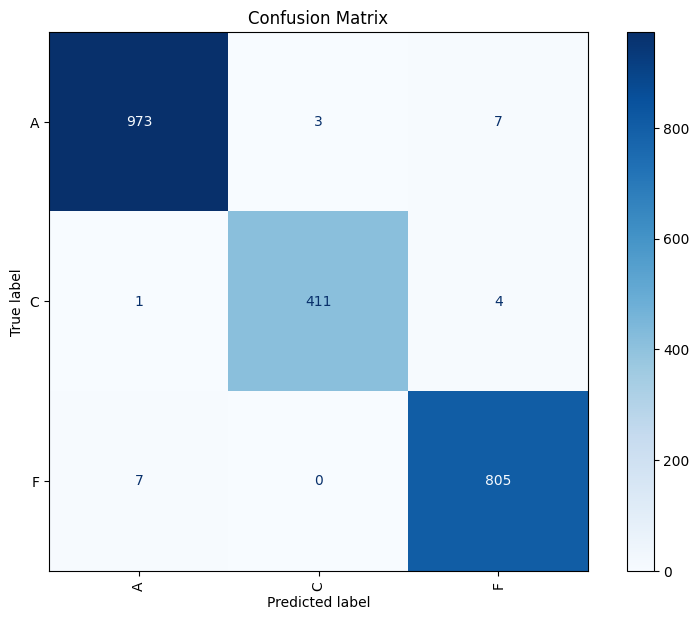

Classification report saved to 'classification_report.txt'


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Convert numerical labels to string labels for classification report
class_names = [str(cls) for cls in label_encoder.classes_]

# Step 2: Generate the classification report
print("\nClassification Report:")
report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)

# Print the report
for key, values in report.items():
    if key != "accuracy":
        print(f"{key}:")
        for metric, value in values.items():
            print(f"  {metric}: {value:.2f}")
    else:
        print(f"accuracy: {values:.2f}")

# Step 3: Display confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

# Optional: Save classification report as a text file
with open("classification_report.txt", "w") as f:
    f.write("Classification Report:\n")
    for key, values in report.items():
        if key != "accuracy":
            f.write(f"{key}:\n")
            for metric, value in values.items():
                f.write(f"  {metric}: {value:.2f}\n")
        else:
            f.write(f"accuracy: {values:.2f}\n")
print("Classification report saved to 'classification_report.txt'")


In [12]:
# Evaluate on the test set
test_loss, test_accuracy = model_optimized.evaluate(X_test, y_test)

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9888 - loss: 0.0340


In [14]:
# Enregistrer le modèle sur le bureau sous le nom 'eegmodel.h5'
model_optimized.save("eegmodel.h5")
print("Le modèle a été sauvegardé sous le nom 'eegmodel.h5' sur le bureau.")


Le modèle a été sauvegardé sous le nom 'eegmodel.h5' sur le bureau.
